## Supervised Learning Final Project

This is a fairly simple and straight forward project focusing on genetics data.  The question we start with is given a set of prostate cancer patients, can we classify them into tumor or normal tissue based on the genes that are involved with prostate cancer?

For this we will start with the data downloading it from the Cancer Genome Atlas (https://portal.gdc.cancer.gov/).  This is a bit of a task to get the data downloaded correctly and put in the right place.  Mainly, it is a bunch of UI manipulation to get the data downloaded the way that you want.  There are numerous tutorials out there that can show you how to get this information and restrict it to the proper fields.

TCGA doesn't exactly have normal tissue samples within it's database.  Rather, it has surrounding tissue that has been tested to use in the place of missing normal tissue.  This can complicate some analyses, but for this purpose we don't care.

In [130]:
# Import the data that was obtained from TCGA

normal_df = pd.read_csv('normal.txt', index_col=0).T  # Transpose and set the first column (GeneSymbol) as index
tumor_df = pd.read_csv('tumor.txt', index_col=0).T    # Transpose and set the first column (GeneSymbol) as index


## Exploratory Data Analysis

In [131]:
# First step is to get some basic information

print("Normal DataFrame Shape:", normal_df.shape)
print("Tumor DataFrame Shape:", tumor_df.shape)

# Check for missing values
print("\nMissing Values in Normal DataFrame:", normal_df.isnull().sum().sum())
print("Missing Values in Tumor DataFrame:", tumor_df.isnull().sum().sum())

# Check max and average values

print("\nMissing Values in Normal DataFrame:", normal_df.max())
print("Missing Values in Tumor DataFrame:", tumor_df.max())

# Check real max value

print("\nMissing Values in Normal DataFrame:", normal_df.max().sort_values(ascending=False))
print("Missing Values in Tumor DataFrame:", tumor_df.max().sort_values(ascending=False))




Normal DataFrame Shape: (52, 60660)
Tumor DataFrame Shape: (497, 60660)

Missing Values in Normal DataFrame: 0
Missing Values in Tumor DataFrame: 0

Missing Values in Normal DataFrame: GeneSymbol
TSPAN6        111.8758
TNMD           52.5824
DPM1          162.8129
SCYL3          17.3148
C1orf112        4.1748
                ...   
AC008763.4      0.0249
AL592295.6     24.3267
AC006486.3      0.0000
AL391628.1      0.1797
AP006621.6      1.8073
Length: 60660, dtype: float64
Missing Values in Tumor DataFrame: GeneSymbol
TSPAN6        136.6281
TNMD            6.1874
DPM1          174.0162
SCYL3          22.6370
C1orf112        8.9708
                ...   
AC008763.4      0.0581
AL592295.6     22.7874
AC006486.3      0.0000
AL391628.1      0.8144
AP006621.6      6.2973
Length: 60660, dtype: float64

Missing Values in Normal DataFrame: GeneSymbol
SEMG1         336058.1856
SEMG2         135728.9928
MT-ND4         63965.1804
MSMB           58958.3913
NPY            56558.0827
              

In [132]:
# Gene expression can have wide range of values.  120956 is too big so let's try to log transform this.

import numpy as np

normal_df = np.log(normal_df + 1)
tumor_df = np.log(tumor_df + 1)

# Check real max value

print("\nMissing Values in Normal DataFrame:", normal_df.max().sort_values(ascending=False))
print("Missing Values in Tumor DataFrame:", tumor_df.max().sort_values(ascending=False))




Missing Values in Normal DataFrame: GeneSymbol
SEMG1         12.725043
SEMG2         11.818423
MT-ND4        11.066110
MSMB          10.984604
NPY           10.943041
                ...    
OR6C76         0.000000
ZNF593         0.000000
Y_RNA          0.000000
RNU6-449P      0.000000
AL353997.3     0.000000
Length: 60660, dtype: float64
Missing Values in Tumor DataFrame: GeneSymbol
MT-RNR2       11.703196
IGKC          11.533245
MT-ND4        11.436766
MT-CO3        11.425200
MT-CO2        11.365310
                ...    
AL133410.3     0.000000
AC106886.5     0.000000
AC008581.1     0.000000
AC109486.3     0.000000
AC098484.1     0.000000
Length: 60660, dtype: float64


C:\Users\dvanbooven\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dvanbooven\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


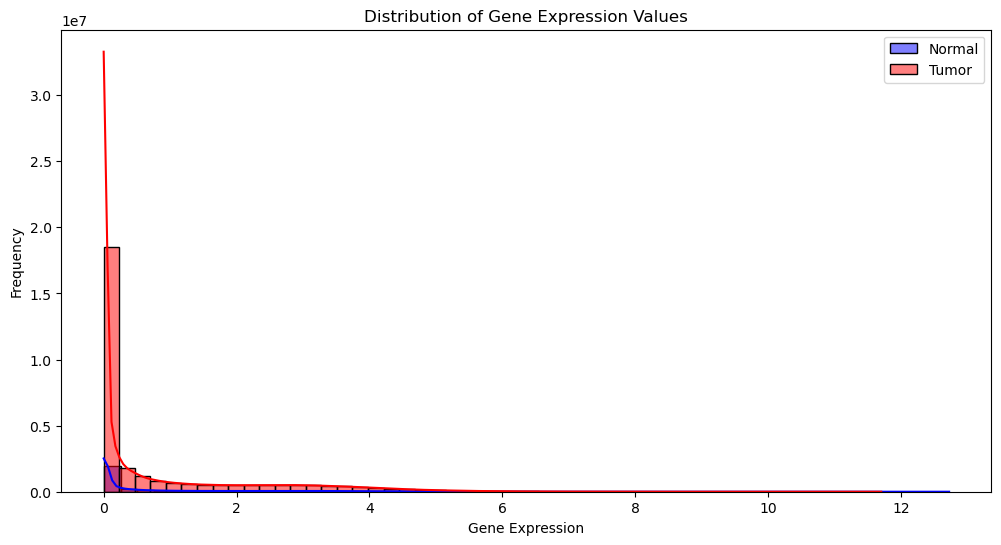

In [133]:
# Check the distribution of Gene Expression Values

# Let's subset.  60K values takes a long time on a simple machine.  Let's look at the first 1000 genes

normal_df_1K = normal_df.iloc[:1000]
tumor_df_1K = tumor_df.iloc[:1000]


plt.figure(figsize=(12, 6))
sns.histplot(normal_df_1K.values.flatten(), bins=50, color='blue', label='Normal', kde=True)
sns.histplot(tumor_df_1K.values.flatten(), bins=50, color='red', label='Tumor', kde=True)
plt.title('Distribution of Gene Expression Values')
plt.xlabel('Gene Expression')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [134]:
# That's an awful lot of 0's.  Let's remove them.

# Add the label column to indicate normal (0) and tumor (1) status
normal_df['Label'] = 0  # Normal samples are labeled as 0
tumor_df['Label'] = 1   # Tumor samples are labeled as 1

# Combine the two DataFrames (normal and tumor)
combined_df = pd.concat([normal_df, tumor_df], axis=0)

filtered_df = combined_df.loc[:, combined_df.sum() > 100]

print("Tumor DataFrame Shape:", filtered_df.shape)

Tumor DataFrame Shape: (549, 25677)


GeneSymbol          AR        KLK3        PTEN        TP53         ERG
count       549.000000  549.000000  549.000000  549.000000  549.000000
mean          3.967581    9.316864    3.222247    3.609323    2.900050
std           0.488126    0.990835    0.527577    0.471165    1.626492
min           2.452401    1.928590    0.994288    1.369275    0.437739
25%           3.632254    9.051101    2.983123    3.427836    1.573023
50%           3.954383    9.536852    3.322785    3.683558    2.123219
75%           4.313389    9.840564    3.554465    3.882431    4.697529
max           6.204963   10.678389    4.718860    4.582873    6.102934


<Axes: xlabel='GeneSymbol'>

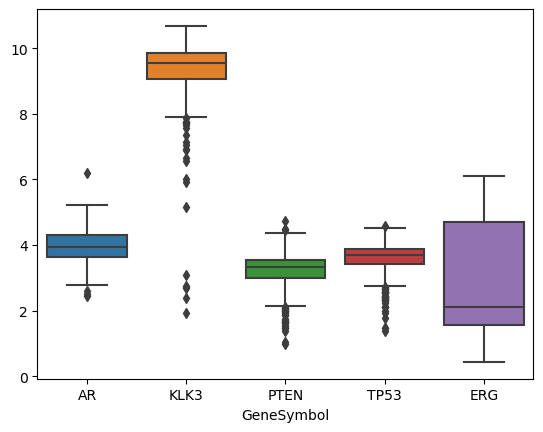

In [135]:
# Let's check a few prostate cancer important genes expression ...

columns_to_keep = ['AR', 'KLK3', 'PTEN', 'TP53', 'ERG']

filtered_df_2 = filtered_df[columns_to_keep]

print(filtered_df_2.describe())


sns.boxplot(data=filtered_df_2)


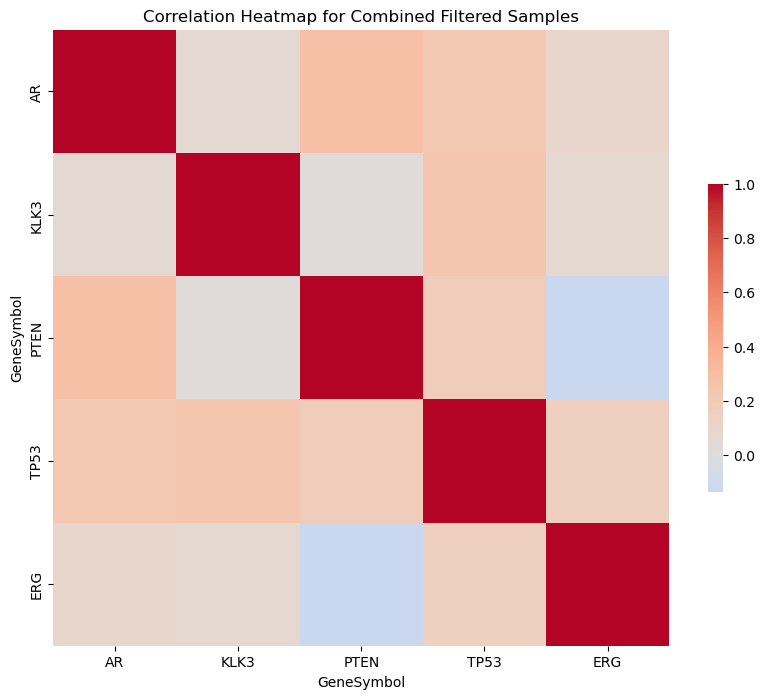

In [136]:
# Do some correlation analysis and plot a heatmap

plt.figure(figsize=(10, 8))
correlation_matrix = filtered_df_2.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': 0.5})
plt.title('Correlation Heatmap for Combined Filtered Samples')
plt.show()


## Model Generation
For this project I've selected to use a logistic regression model.  This fits in perfectly with the categorical yes/no output, but in this case it's an evaluation of tumor vs normal sample.

In [137]:
# We are ready to bulid the model.  Let's create X and y and split
X = filtered_df.drop(columns=['Label'])  # Drop the 'Label' column to get the features
y = filtered_df['Label']  # The 'Label' column is the target variable (normal or tumor)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature values (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Train the model
logreg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_scaled)





## Model Evaluation

Accuracy: 0.9454545454545454
Confusion Matrix:
[[ 7  3]
 [ 3 97]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.97      0.97      0.97       100

    accuracy                           0.95       110
   macro avg       0.83      0.83      0.83       110
weighted avg       0.95      0.95      0.95       110



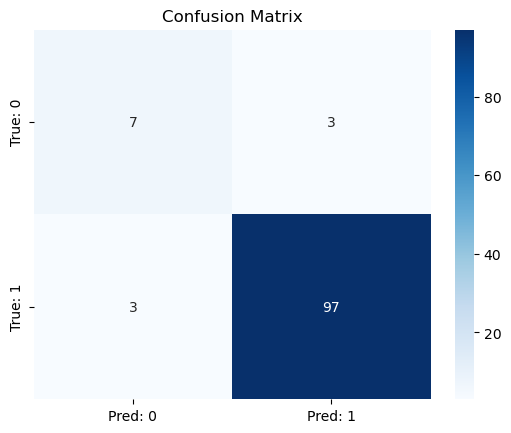

In [138]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred: 0", "Pred: 1"], yticklabels=["True: 0", "True: 1"])
plt.title("Confusion Matrix")
plt.show()
